<h1>Visualizing Class-Specific Saliency Map in PyTorch's EfficientNet</h1>
Saliency in an image refers to what is perceptible or important to the computer vision system. When applied to convolutional neural networks, the saliency map represents the essential pixels in the image that influence the network's prediction. This code has been adapted to create specific saliency maps for each class, with the goal of observing the points where the network concentrates its attention when classifying X-ray images related to bone health.

The project focuses on improving the interpretability of convolutional networks by enabling the visualization of locations that the network deems relevant for decision-making regarding bone health. This saliency map technique is valuable for medical professionals and researchers as it provides insights into the specific features or patterns that the neural network uses for classification.

Original source of the code: https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

<h1>Visualizando o Mapa de Saliência de Classe Específica na EfficientNet do PyTorch</h1>

A saliência em uma imagem refere-se ao que é perceptível ou importante para o sistema de visão computacional. Quando aplicado em redes neurais convolucionais, o mapa de saliência representa os pixels essenciais na imagem que influenciam a previsão da rede. Este código foi adaptado para criar mapas de saliência específicos para cada classe, com o objetivo de observar os pontos em que a rede concentra sua atenção ao classificar imagens de raio-x relacionadas à saúde óssea.

O projeto se concentra em melhorar a interpretabilidade das redes convolucionais ao permitir a visualização dos locais que a rede considera relevantes para a tomada de decisão em relação à saúde óssea. Essa técnica de mapa de saliência é valiosa para profissionais da área médica e pesquisadores, pois fornece insights sobre as características ou padrões específicos que a rede neural utiliza para realizar a classificação.

Fonte original do código: https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

In [30]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

EN: Loads the pre-trained weights into the model. Additionally, transformations are defined to preprocess and normalize the input images before passing them to the model during inference. The code also adjusts the expected size of the image based on the selected model.

PT-BR: Carrega os pesos pré-treinados no modelo. Além disso, são definidas transformações para pré-processar e normalizar as imagens de entrada antes de passá-las para o modelo durante a inferência. O código também ajusta o tamanho esperado da imagem com base no modelo selecionado.

In [31]:
MODEL_PATH = '/d01/scholles/gigasistemica/saved_models/Cropped/efficientnet-b6_AUG_RB_NEW_CVAT_C1_C3_Cropped_600x600_Batch8_200Ep/efficientnet-b6_AUG_RB_NEW_CVAT_C1_C3_Cropped_600x600_Batch8_200Ep_test.pth'
MODEL = 'efficientnet-' + re.findall(r'efficientnet-(b\d)', MODEL_PATH)[0] if re.findall(r'efficientnet-(b\d)', MODEL_PATH) else None
TEST_IMGS_NUMBER = 20

resize_mapping = {'efficientnet-b0': (224, 224),
                  'efficientnet-b1': (240, 240),
                  'efficientnet-b2': (260, 260),
                  'efficientnet-b3': (300, 300),
                  'efficientnet-b4': (380, 380),
                  'efficientnet-b5': (456, 456),
                  'efficientnet-b6': (528, 528),
                  'efficientnet-b7': (600, 600)}

RESIZE = resize_mapping.get(MODEL, None)

if 'C2C3' in MODEL_PATH:
    diagnosticos = {0: 'Osso Saudável', 1: 'Osso Doente'}
else:
    diagnosticos = {0: 'Alta porosidade óssea não detectada', 1: 'Alta porosidade óssea detectada'}

#load pretrained resnet model
model = EfficientNet.from_pretrained(MODEL)
state_dict = torch.load(MODEL_PATH)
model.load_state_dict(state_dict)
#print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.ToTensor(),
    normalize
])

Loaded pretrained weights for efficientnet-b6


EN: The code implements the saliency function, which takes an input image and a deep learning model. This function calculates and displays a saliency map, highlighting the relevant regions of the image for the model's predictions. The process involves preprocessing the image, computing the gradients of the highest scoring class with respect to the image, and normalizing the intensity of the gradients. Then, a hot colormap is applied to the saliency map, followed by thresholding to highlight the most important areas. The function creates a figure with three subplots showing the original image, the saliency map, and the overlay of the two. Additionally, the associated diagnosis for the image is displayed based on the model's predictions.

PT-BR: O código implementa a função saliency, que recebe uma imagem de entrada e um modelo de aprendizado profundo. Essa função calcula e exibe um mapa de saliência, destacando as regiões relevantes da imagem para as previsões do modelo. O processo envolve pré-processamento da imagem, cálculo dos gradientes da classe de maior pontuação em relação à imagem e normalização da intensidade dos gradientes. Em seguida, é aplicado um colormap quente ao mapa de saliência e um thresholding para destacar as áreas mais importantes. A função cria uma figura com três subplots mostrando a imagem original, o mapa de saliência e a sobreposição das duas. Além disso, o diagnóstico associado à imagem é exibido com base nas previsões do modelo.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
        
    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
        
    imagem_hot = plt.cm.hot(slc)
    original = np.clip(np.transpose(input_img.detach().numpy(), (1, 2, 0)), 0, 1)

    # Multiplicar o canal vermelho da imagem "hot" pela intensidade desejada do vermelho
    intensity = 1.5  # Intensidade do vermelho (ajuste conforme necessário)
    red_channel = imagem_hot[:, :, 0] * intensity
    
    # Aplicar o threshold ao canal vermelho
    threshold = 0.3
    red_channel = np.where(red_channel < threshold, 0, red_channel)

    # Sobrepor o canal vermelho modificado na imagem original
    overlay = np.clip(original + red_channel[:, :, np.newaxis], 0, 1)
        
    # Plot the image, saliency map, and overlay
    plt.figure(figsize=(18, 6), facecolor='none')  # Configurando o fundo como transparente
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image', fontweight='bold', color='white')

    plt.subplot(1, 3, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.title('Saliency Map', fontweight='bold', color='white')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.xticks([])
    plt.yticks([])
    plt.title('Overlay', fontweight='bold', color='white')

    diagnosis = 'Diagnóstico: ' + diagnosticos[indices.item()]
    plt.suptitle(diagnosis, fontsize=40, y=1.05, fontweight='bold', color='white')

    plt.tight_layout()
    plt.show()

EN: The function select_random_images takes the path of a folder and the number of images num_images as arguments. The purpose of this function is to randomly select a certain number of images from the provided folder. Initially, the function lists all the files contained in the folder. Then, it filters only the files that are images based on their extensions (e.g., .png, .jpg, .jpeg, .gif). If the folder does not contain enough images for the specified quantity, the function raises a value exception to generate an error. Otherwise, the function uses the random module to randomly select the specified number of images from the list of image files. It then creates the full path for each selected image and returns a list containing these full paths.

PT-BR: A função select_random_images recebe o caminho de uma pasta e um número de imagens num_images como argumentos. Essa função tem a finalidade de selecionar aleatoriamente um determinado número de imagens a partir da pasta fornecida. Inicialmente, a função lista todos os arquivos contidos na pasta. Em seguida, filtra apenas os arquivos que são imagens com base em suas extensões (por exemplo, .png, .jpg, .jpeg, .gif). Caso a pasta não contenha imagens suficientes para a quantidade especificada, a função gera um erro através do levantamento de uma exceção de valor. Caso contrário, a função utiliza o módulo random para selecionar aleatoriamente o número especificado de imagens da lista de arquivos de imagem. Em seguida, ela cria o caminho completo para cada imagem selecionada e retorna uma lista contendo esses caminhos completos.

In [33]:
def select_random_images(folder_path, num_images=TEST_IMGS_NUMBER):
    # Lista todos os arquivos da pasta
    all_files = os.listdir(folder_path)
    
    # Filtra apenas os arquivos que são imagens (por extensão)
    image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    
    # Se a pasta não tiver imagens suficientes, trata o caso
    if len(image_files) < num_images:
        raise ValueError("A pasta não contém imagens suficientes.")
    
    # Seleciona aleatoriamente num_images imagens
    selected_images = random.sample(image_files, num_images)
    
    # Cria o caminho completo para cada imagem selecionada
    image_paths = [os.path.join(folder_path, image) for image in selected_images]
    
    return image_paths

EN: A set of images is randomly selected from a specific directory. For each selected image, the saliency function is called to generate and display the saliency map of the image using the trained model.

PT-BR: Um conjunto de imagens é selecionado aleatoriamente de um diretório específico. Para cada imagem selecionada, a função saliency é chamada para gerar e exibir o mapa de saliência da imagem usando o modelo treinado.

<h1>C3</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


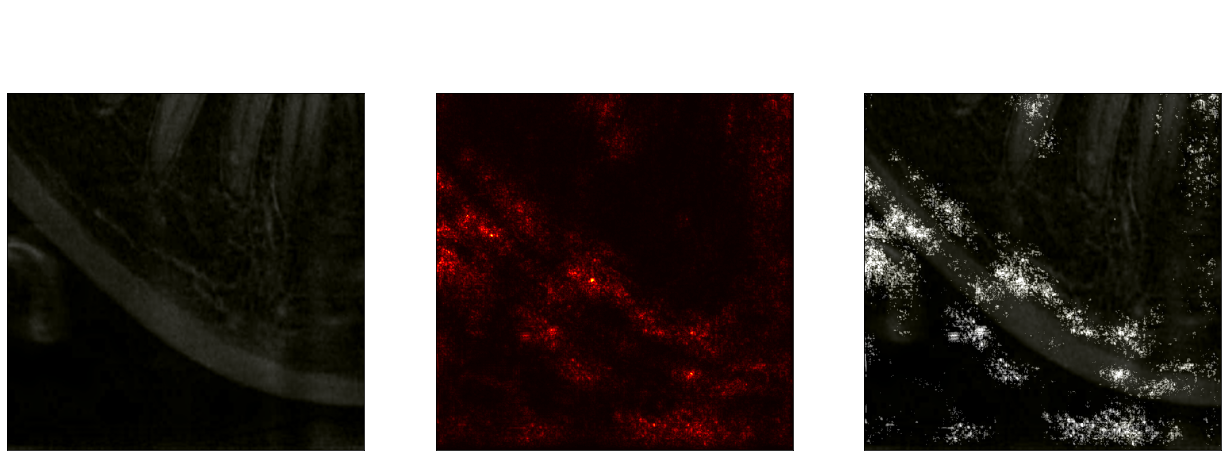

In [34]:
img_path = '/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_NEW_CVAT_C1_C3_Cropped_600x600/test/C1/OPHUB2017-0161[946.34, 1158.71, 121.57, 80.09].jpg'
img = Image.open(img_path).convert('RGB')
saliency(img, model)